In [1]:

#!pip install --upgrade ../../tradeframework
#!pip install --upgrade ~/Development/repos/quantutils

#import tradeframework
from tradeframework.api import Derivative, Portfolio, Optimizer, Model, TradeEnvironment, TradeEngine, AssetInfo
from tradeframework.environments import SandboxEnvironment, SandboxContext, ZiplineEnvironment
from tradeframework.models import PreOpenMomentum




In [2]:
import pandas as pd
import numpy as np

import matplotlib

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

# STRATEGY SET UP
txCost = 0
ts = pd.read_csv('data/WallSt-hourly-all.txt', index_col=0, parse_dates=[[0, 1]], dayfirst=True )
#ts = ts["2016-07-06":]

import pytz
# PreOpenMomentum model relies on timeseries being in local time zone
ts.index = ts.index.tz_localize("Europe/London").tz_convert("US/Eastern")

# Resample into hourly data
#order = ts.columns
#ts = ts.resample('5min').agg({'Open': 'first', 'High': 'max', 'Low': 'min','Close': 'last'})[order]


# Remove hours we are not interested in
#ts[(ts.index.hour > 19) | (ts.index.hour < 12)] = np.nan

# Resample into Business Days
#ts = ts.resample('5min').agg({'Open': 'first', 'High': 'max', 'Low': 'min','Close': 'last'})[order]
#

In [147]:
import quantutils.dataset.pipeline as ppl
class RetraceDailyMove(Model):
    def __init__(self, name, env, start=None, end=None):
        Model.__init__(self, name, env)
        self.start = start
        self.end = end
        self.env
        return
    
    def handleData(self, context, assetInfo):
        Model.handleData(self, context, assetInfo)
        
        signals = pd.DataFrame(np.zeros((len(assetInfo.values), 2)), index=assetInfo.values.index, columns=["bar","gap"])

        if (self.start is not None):
            scope = ppl.cropTime(assetInfo.values["Open"], self.start, self.end)
        else:
            scope = assetInfo.values["Open"]
            
        print(scope["09-12-16":"09-23-16"])
        sig = signals.loc[scope.index][1:]
        sig["bar"] = np.negative(np.sign(np.diff(scope)))
        signals.loc[sig.index] = sig

        return self.getDerivativeInfo(context, [assetInfo], [signals])

In [172]:
import quantutils.dataset.pipeline as ppl
class Momentum(Model):
    def __init__(self, name, env, start=None, end=None):
        Model.__init__(self, name, env)
        self.start = start
        self.end = end
        self.env
        return
    
    def handleData(self, context, assetInfo):
        Model.handleData(self, context, assetInfo)
        
        signals = pd.DataFrame(np.zeros((len(assetInfo.values), 2)), index=assetInfo.values.index, columns=["bar","gap"])

        if (self.start is not None):
            scope = ppl.cropTime(assetInfo.values, self.start, self.end)
        else:
            scope = assetInfo.values
            
        sig = signals.loc[scope.index][1:]
        sig["bar"] = np.sign((scope["Close"] - scope["Open"]).values[:-1])
        signals.loc[sig.index] = sig

        return self.getDerivativeInfo(context, [assetInfo], [signals])

In [160]:
import quantutils.dataset.pipeline as ppl
class MeanReversion(Model):
    def __init__(self, name, env, start=None, end=None):
        Model.__init__(self, name, env)
        self.start = start
        self.end = end
        self.env
        return
    
    def handleData(self, context, assetInfo):
        Model.handleData(self, context, assetInfo)
        
        signals = pd.DataFrame(np.zeros((len(assetInfo.values), 2)), index=assetInfo.values.index, columns=["bar","gap"])

        if (self.start is not None):
            scope = ppl.cropTime(assetInfo.values, self.start, self.end)
        else:
            scope = assetInfo.values
            
        sig = signals.loc[scope.index][1:]
        sig["bar"] = np.negative(np.sign((scope["Close"] - scope["Open"]).values[:-1]))
        signals.loc[sig.index] = sig

        return self.getDerivativeInfo(context, [assetInfo], [signals])

In [176]:
bEnv = SandboxEnvironment("TradeFair")
p = bEnv.createPortfolio("Baseline", optimizer=bEnv.createOptimizer("EqualWeightsOptimizer", "EqualWeights"))
p.addModel(bEnv.createModel( "BuyAndHold", "D3-BuyAndHold", args=("14:00", "15:00")))
#p.addModel(MeanReversion("MR-BL", bEnv, "12:00", "13:00" ))
#p.addModel(bEnv.createModel( "BuyAndHold", "D3-BuyAndHold"))
baseline = bEnv.handleData({}, AssetInfo("DOW", ts)).assets[0]

In [177]:
env = SandboxEnvironment("TradeFair")
context = {}

#opt = env.createOptimizer("KellyOptimizer", "KellyOpt", opts={"window":20*24, "weight":.005})
opt = env.createOptimizer("EqualWeightsOptimizer", "EqualWeights", opts={"weight":1.0})
p = env.createPortfolio("MyPortfolio", optimizer=opt)

#p.addModel(MeanReversion("MR1", env, "09:00", "10:00" ))
#p.addModel(MeanReversion("MR2", env, "10:00", "11:00" ))
#p.addModel(Momentum("MR3", env, "11:00", "12:00" ))
#p.addModel(Momentum("MR4", env, "12:00", "13:00" ))
#p.addModel(Momentum("MR5", env, "13:00", "14:00" ))
p.addModel(Momentum("MR6", env, "14:00", "15:00" ))
#p.addModel(Momentum("MR7", env, "15:00", "16:00" ))
#p.addModel(Momentum("MOM1", env, "12:00", "13:00"))

#p.addModel(env.createModel( "PreOpenMomentum", "D1-PreOpenMomentum" ))
#p.addModel(env.createModel( "BuyAndHold", "D2-BuyAndHold" ))

#p.addModel(env.createModel( "BuyAndHold", "D3-BuyAndHold7", args=("09:00", "10:00")))
#p.addModel(env.createModel( "BuyAndHold", "D3-BuyAndHold6", args=("10:00", "11:00")))
#p.addModel(env.createModel( "BuyAndHold", "D3-BuyAndHold5", args=("11:00", "12:00")))
#p.addModel(env.createModel( "BuyAndHold", "D3-BuyAndHold4", args=("12:00", "13:00")))
#p.addModel(env.createModel( "BuyAndHold", "D3-BuyAndHold3", args=("13:00", "14:00")))
#p.addModel(env.createModel( "BuyAndHold", "D3-BuyAndHold2", args=("14:00", "15:00")))
#p.addModel(env.createModel( "BuyAndHold", "D3-BuyAndHold1", args=("15:00", "16:00")))

#p.addModel(env.createModel( "SellAndHold", "D4-SellAndHold", args=("15:00", "16:00")))
threshold = 0
#p.addModel(env.createModel( "MarketInsightsV2Model", "D3-FinalHourML1", args=('cred/MIOapi_cred.json', 'cred/functions_cred.json', '265e2f7f3e06af1c6fc9e74434514c86', 'd2c3feaf6aad96c984f1b65ad4718aa4', threshold)))
#p.addModel(env.createModel( "MarketInsightsV2Model", "D3-FinalHourML2", args=('cred/MIOapi_cred.json', 'cred/functions_cred.json', '265e2f7f3e06af1c6fc9e74434514c86', '5404d26bccc568c4bddfc45f37d8fbfb', threshold)))
#p.addModel(env.createModel( "MarketInsightsV2Model", "D3-FinalHourML3", args=('cred/MIOapi_cred.json', 'cred/functions_cred.json', '265e2f7f3e06af1c6fc9e74434514c86', '9c92fb9e92ce3c502995b77eca6d617f', threshold)))
#p.addModel(env.createModel( "MarketInsightsV2Model", "D3-FinalHourML4", args=('cred/MIOapi_cred.json', 'cred/functions_cred.json', '265e2f7f3e06af1c6fc9e74434514c86', 'b765be85d6b48ee7db41548fb4424f9e', threshold)))

# Feed data into the portfolio

#for index in range(0, len(ts)):
#env.handleData(0, ts[:index+1])
dInfo = env.handleData(context, AssetInfo("DOW", ts)) # TODO this should be "getDerivative" or "backTest"


Derivative name : MyPortfolio
Number of assets : 1
Baseline name : Baseline


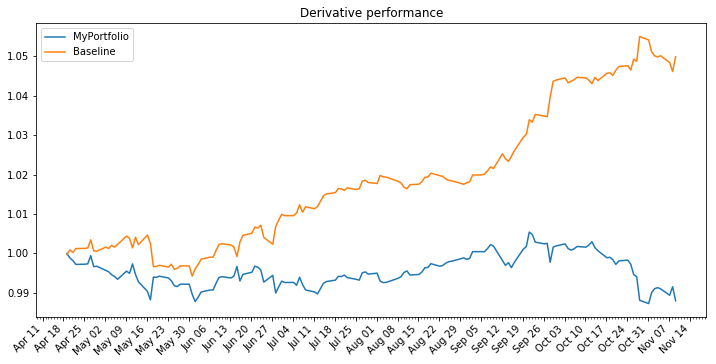

TradeFair_Portfolio                            DOW  \
                                      Capital                     Allocation   
                                         Open            Close           bar   
Date_Time                                                                      
2016-04-20 14:00:00-04:00    10000.0000000000  9988.4233737596 -0.5512679162   
2016-04-21 14:00:00-04:00     9988.4233737596  9981.9879986514  0.5547737162   
2016-04-22 14:00:00-04:00     9981.9879986514  9972.0559483359 -0.5548631461   
2016-04-25 14:00:00-04:00     9972.0559483359  9972.5561601480  0.5557909023   
2016-04-26 14:00:00-04:00     9972.5561601480  9973.5556312583  0.5552617279   
...                                       ...              ...           ...   
2016-11-03 14:00:00-04:00     9910.5121321607  9913.0512934558 -0.5519915859   
2016-11-04 14:00:00-04:00     9913.0512934558  9910.1275289046 -0.5516536889   
2016-11-07 14:00:00-05:00     9910.1275289046  9893.8315507273  0.5431992726   
2016-11-08 14:00:00-05:00     9893.8315507273  9915.3720739021 -0.5385130794   
2016-11-09 14:00:00-05:00     9915.3720739021  9879.7911071796 -0.5350521312   

                                                            
                                       Trade                
                           gap           bar           gap  
Date_Time                                                   
2016-04-20 14:00:00-04:00  0.0 -0.5512679162  0.5512679162  
2016-04-21 14:00:00-04:00  0.0  0.5547737162 -0.5547737162  
2016-04-22 14:00:00-04:00  0.0 -0.5548631461  0.5548631461  
2016-04-25 14:00:00-04:00  0.0  0.5557909023 -0.5557909023  
2016-04-26 14:00:00-04:00  0.0  0.5552617279 -0.5552617279  
...                        ...           ...           ...  
2016-11-03 14:00:00-04:00  0.0 -0.5519915859  0.5519915859  
2016-11-04 14:00:00-04:00  0.0 -0.5516536889  0.5516536889  
2016-11-07 14:00:00-05:00  0.0  0.5431992726 -0.5431992726  
2016-11-08 14:00:00-05:00  0.0 -0.5385130794  0.5385130794  
2016-11-09 14:00:00-05:00  0.0 -0.5350521312  0.5350521312  

[143 rows x 6 columns]

Merton measure of Market Timing : 72.81% predictability
p1 + p2 : 1.0392633070228698
p-value : 0.271892807223321



Start date,2016-04-19
End date,2016-11-09
Total months,164
,Backtest
Annual return,-0.1%
Cumulative returns,-1.2%
Annual volatility,0.5%
Sharpe ratio,-0.17
Calmar ratio,-0.05
Stability,0.13
Max drawdown,-1.8%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,1.81,2016-09-22,2016-10-31,NaT,NaN
1,1.22,2016-04-20,2016-06-01,2016-09-02,98
2,0.58,2016-09-09,2016-09-15,2016-09-21,9
3,0.00,2016-04-19,2016-04-19,2016-04-19,1
4,0.00,2016-04-19,2016-04-19,2016-04-19,1


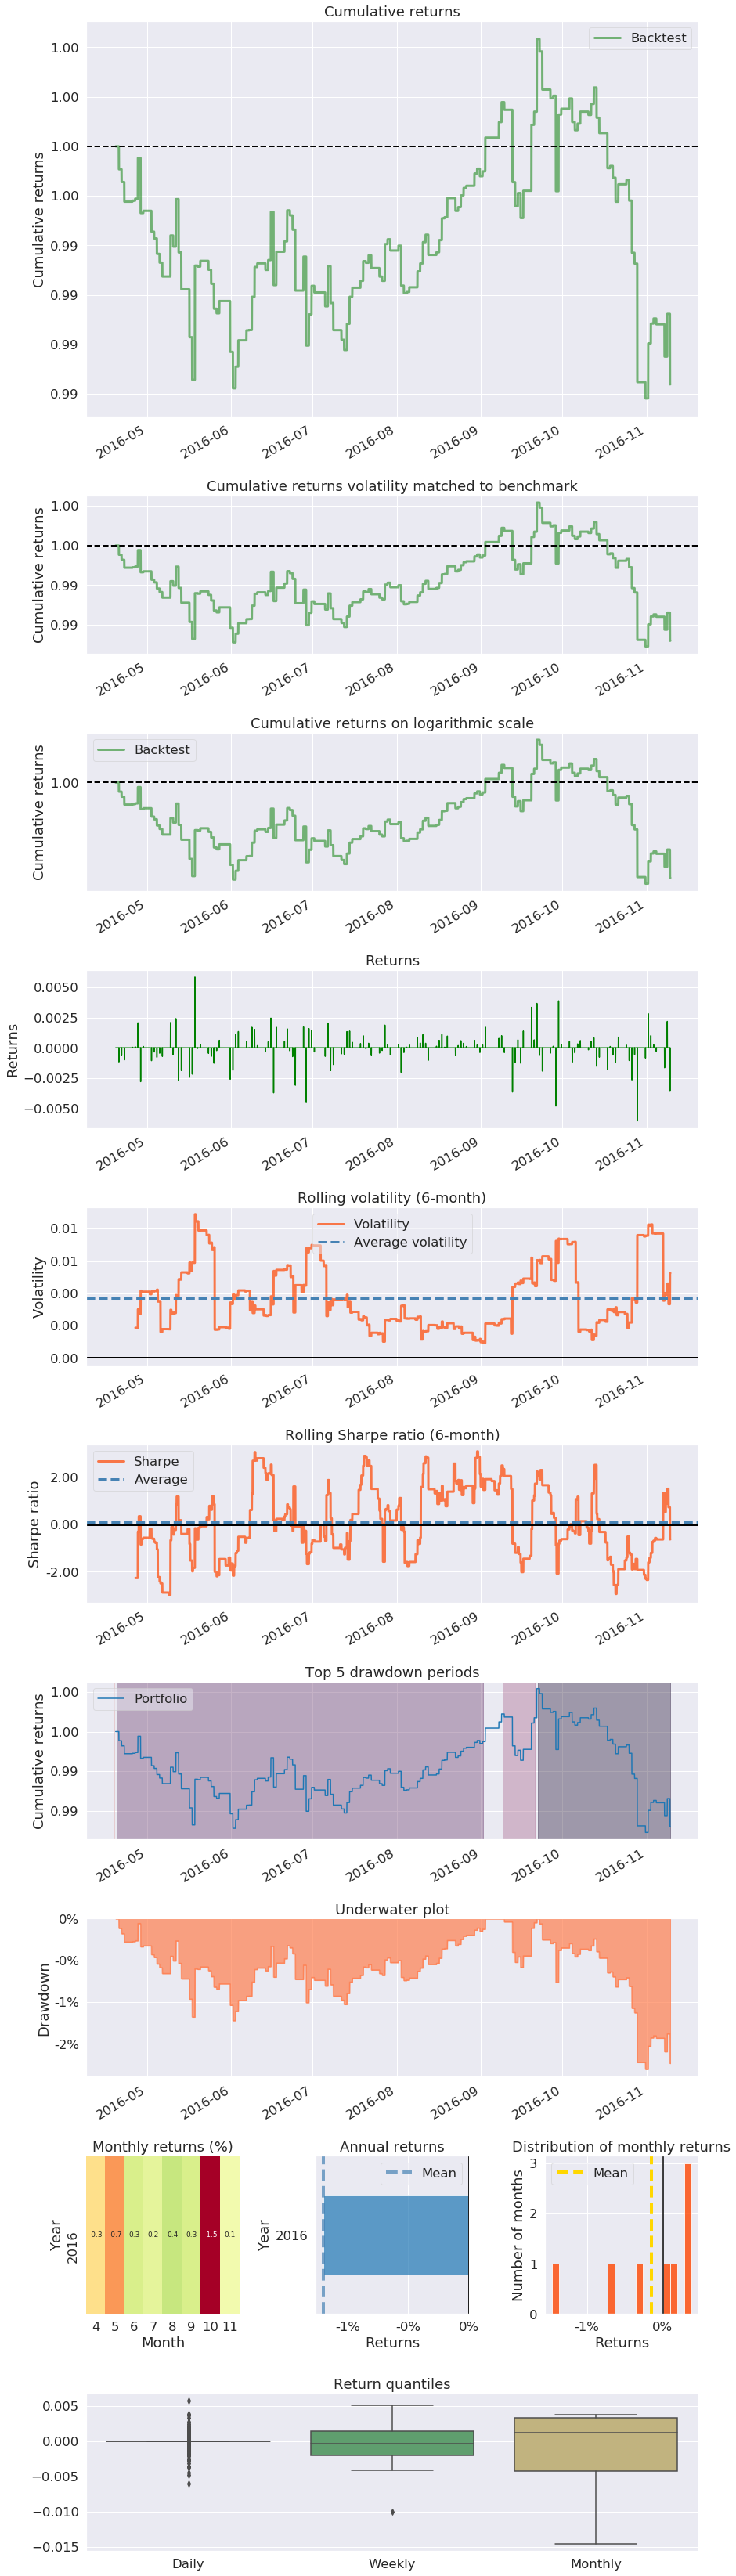

In [178]:
import tradeframework.utils.trader as trader
tInfo = env.getTradingInfo(context, dInfo, 10000)
trader.displaySummary(dInfo.assets[0], tInfo, baseline, includeComponents=False, includePrimary=True)

In [33]:
import numpy as np 
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    result = result[result.size//2:]
    result = result / max(result)
    return result

In [102]:
def ac_win(dRet, window=20, lag=1):
    ac = [0] * (window//2)
    for i in range(window, len(dRet)):
        sample = dRet[i-window:i]
        ac.append(autocorr(sample)[lag])
    return ac

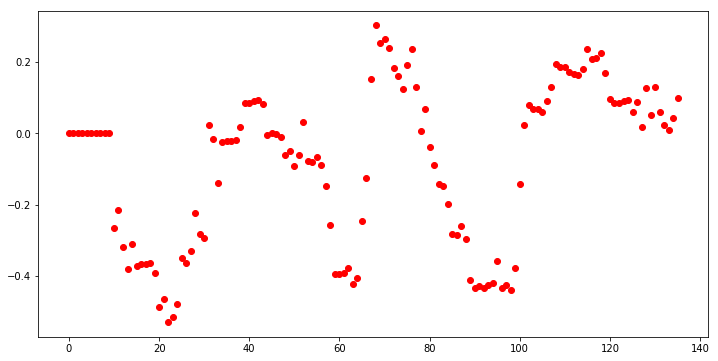

In [120]:
#pyplot.plot(ac_win(dRet))
pyplot.plot(ac_win(x, lag=1), 'ro')
pyplot.show()

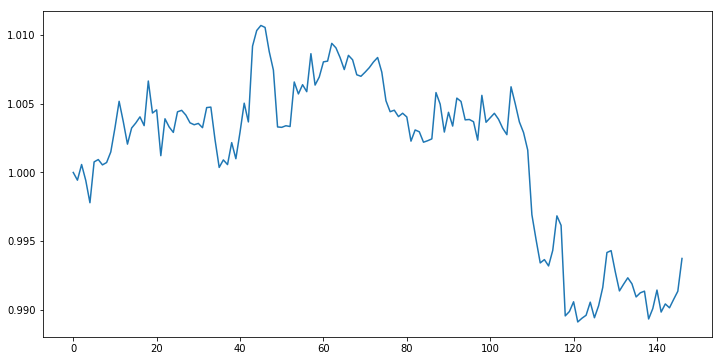

In [121]:

from matplotlib import pyplot
pyplot.plot(tInfo.values[:,0]/10000)
pyplot.show()

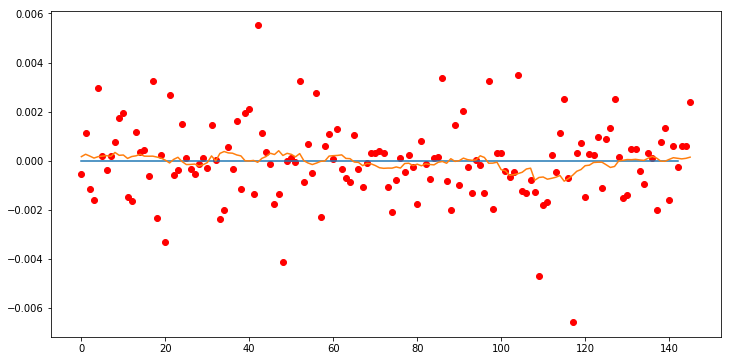

In [122]:

from matplotlib import pyplot
x = np.diff(tInfo.values[:,0]/10000)
lags = 20
ma = np.convolve(x, np.ones((lags,))/lags, mode='same')
pyplot.plot(x,'ro')
pyplot.plot([0] * len(x1))
pyplot.plot(ma)
pyplot.show()

In [119]:
import statsmodels.api as sm

x = (tInfo["TradeFair_Portfolio"]["Capital"]["Open"].diff()/tInfo["TradeFair_Portfolio"]["Capital"]["Open"])[1:]

x

Date_Time
2016-04-20 12:00:00-04:00   -0.0005607062
2016-04-21 12:00:00-04:00    0.0011370159
2016-04-22 12:00:00-04:00   -0.0011594943
2016-04-25 12:00:00-04:00   -0.0016223449
2016-04-26 12:00:00-04:00    0.0029649280
                                 ...     
2016-11-03 12:00:00-04:00    0.0005943157
2016-11-04 12:00:00-04:00   -0.0002835712
2016-11-07 12:00:00-05:00    0.0006183810
2016-11-08 12:00:00-05:00    0.0005975222
2016-11-09 12:00:00-05:00    0.0023969866
Name: Open, Length: 146, dtype: float64

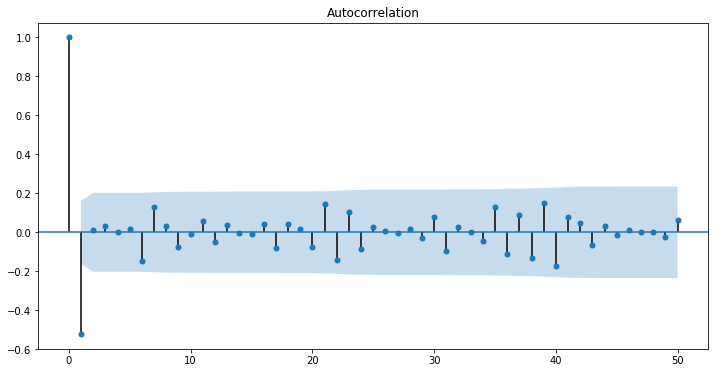

(-2.5611866900520868,
 0.10128742071727043,
 0,
 145,
 {'1%': -3.476273058920005,
  '5%': -2.881687616548444,
  '10%': -2.5775132580261593},
 -2009.1837538474956)

In [123]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
plot_acf(np.diff(x), lags=50)
pyplot.show()
adfuller(ma)

In [124]:
import statsmodels.api as sm

# Fit the model
#x = x - x.mean()
mod_data = sm.tsa.MarkovAutoregression(x, k_regimes=2, order=1, trend='nc', switching_variance=True)
res_data = mod_data.fit()

res_data.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                        y   No. Observations:                  145
Model:             MarkovAutoregression   Log Likelihood                 738.310
Date:                  Fri, 27 Jul 2018   AIC                          -1464.620
Time:                          17:18:15   BIC                          -1446.760
Sample:                               0   HQIC                         -1457.363
                                  - 145                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.926e-07        nan        nan        nan         nan         nan
ar.L1         -0.2555      0.104     -2.461      0.014      -0.459      -0.052
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.485e-06   5.23e-07      6.660      0.000    2.46e-06    4.51e-06
ar.L1         -0.0173      0.117     -0.148      0.882      -0.246       0.211
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.3326      0.105      3.177      0.001       0.127       0.538
p[1->0]        0.2930      0.092      3.177      0.001       0.112       0.474
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

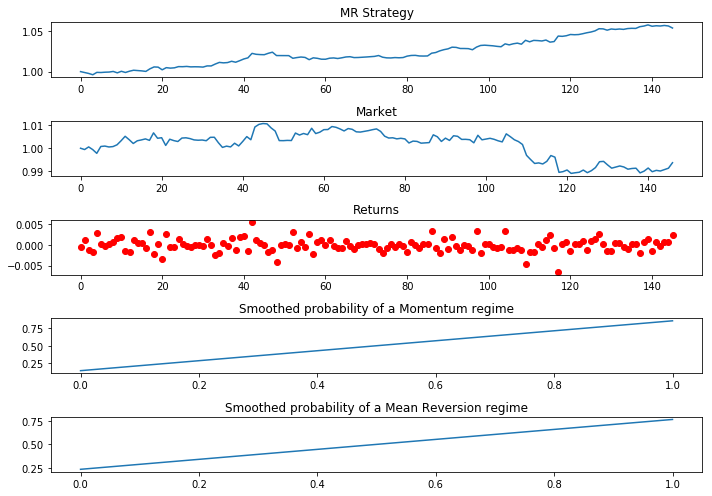

In [125]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(5, figsize=(10,7))

bInfo = bEnv.getTradingInfo(context, baseline, startCapital=1)
ax = axes[0]
ax.plot(bInfo.values[:,0])
ax.set(title='MR Strategy')

ax = axes[1]
ax.plot(tInfo.values[:,0]/10000)
ax.set(title='Market')

ax = axes[2]
ax.plot(x, 'ro')
ax.set(title='Returns')

ax = axes[3]
ax.plot(res_data.filtered_marginal_probabilities[0])
ax.set(title='Smoothed probability of a Momentum regime')

ax = axes[4]
ax.plot(res_data.filtered_marginal_probabilities[1])
ax.set(title='Smoothed probability of a Mean Reversion regime')

#ax = axes[4]
#ax.plot(res_data.filtered_marginal_probabilities[2])
#ax.set(title='Smoothed probability of a High Mean Reversion regime')

fig.tight_layout()

In [107]:
res_data.expected_durations

array([6.60991885, 4.72710827])